# **THIRD ITERATION: COMPARATIVE**

###### Walmart Sales Exploratory Data Analysis

This notebook continues the first and second iterations after measuring per store vs all stores data. Following is the comparative analysis and short-term forecasting....


###### Objective:
- Compare sales patterns across stores and time periods
- Shape and preprocess the data to train machine learning model
- Set up code foundations for predictive analysis


Next iteration will focus on integrating the data to train a SARIMA model, moving from EDA to ML....


## Data Wrangling

### Loading Data & Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

Add the .csv file from github to Notebook environment and read the .csv file.

Further, check the dataset's columns & rows, missing values, and date type.

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/brownbreadandjam/ml-walmart-sales-model/iterated/walmart.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)



print(f"Shape: {data.shape}")
print(f"Date range: {data['Date'].min().strftime('%Y-%m-%d')} to {data['Date'].max().strftime('%Y-%m-%d')}")
print(f"Stores: {data['Store'].nunique()}, Weeks: {data['Date'].nunique()}")
print(f"Missing values: {data.isnull().sum().sum()}")

Shape: (6435, 8)
Date range: 2010-02-05 to 2012-10-26
Stores: 45, Weeks: 143
Missing values: 0


## Sales Measures

### Holiday Measures

In [5]:
holiday_sales = data[data['Holiday_Flag'] == 1]['Weekly_Sales'].mean()
regular_sales = data[data['Holiday_Flag'] == 0]['Weekly_Sales'].mean()
holiday_lift = ((holiday_sales / regular_sales - 1) * 100)

print(f"\nHoliday Impact: +{holiday_lift:.1f}%")
print(f"Regular: ${regular_sales:,.0f} | Holiday: ${holiday_sales:,.0f}")


Holiday Impact: +7.8%
Regular: $1,041,256 | Holiday: $1,122,888


### Time Series - Dual Approach

In [6]:
# Approach 1: Total aggregated (Base Model)
data_indexed = data.set_index('Date')
sales_total = data_indexed['Weekly_Sales'].resample('W').sum().replace(0, np.nan).fillna(method='ffill')

# Approach 2: Average per store (Our Model)
sales_avg = data.groupby('Date')['Weekly_Sales'].mean()

### Time Series Comparison

In [7]:
print(f"\n=== TIME SERIES COMPARISON ===")
print(f"Total Sales Approach (Base Model):")
print(f"  Weekly range: ${sales_total.min():,.0f} - ${sales_total.max():,.0f}")
print(f"  Mean: ${sales_total.mean():,.0f}")

print(f"\nAverage Sales Approach (Our Model):")
print(f"  Weekly range: ${sales_avg.min():,.0f} - ${sales_avg.max():,.0f}")
print(f"  Mean: ${sales_avg.mean():,.0f}")


=== TIME SERIES COMPARISON ===
Total Sales Approach (Base Model):
  Weekly range: $39,599,853 - $80,931,416
  Mean: $47,113,419

Average Sales Approach (Our Model):
  Weekly range: $879,997 - $1,798,476
  Mean: $1,046,965


### Time Series Visualization

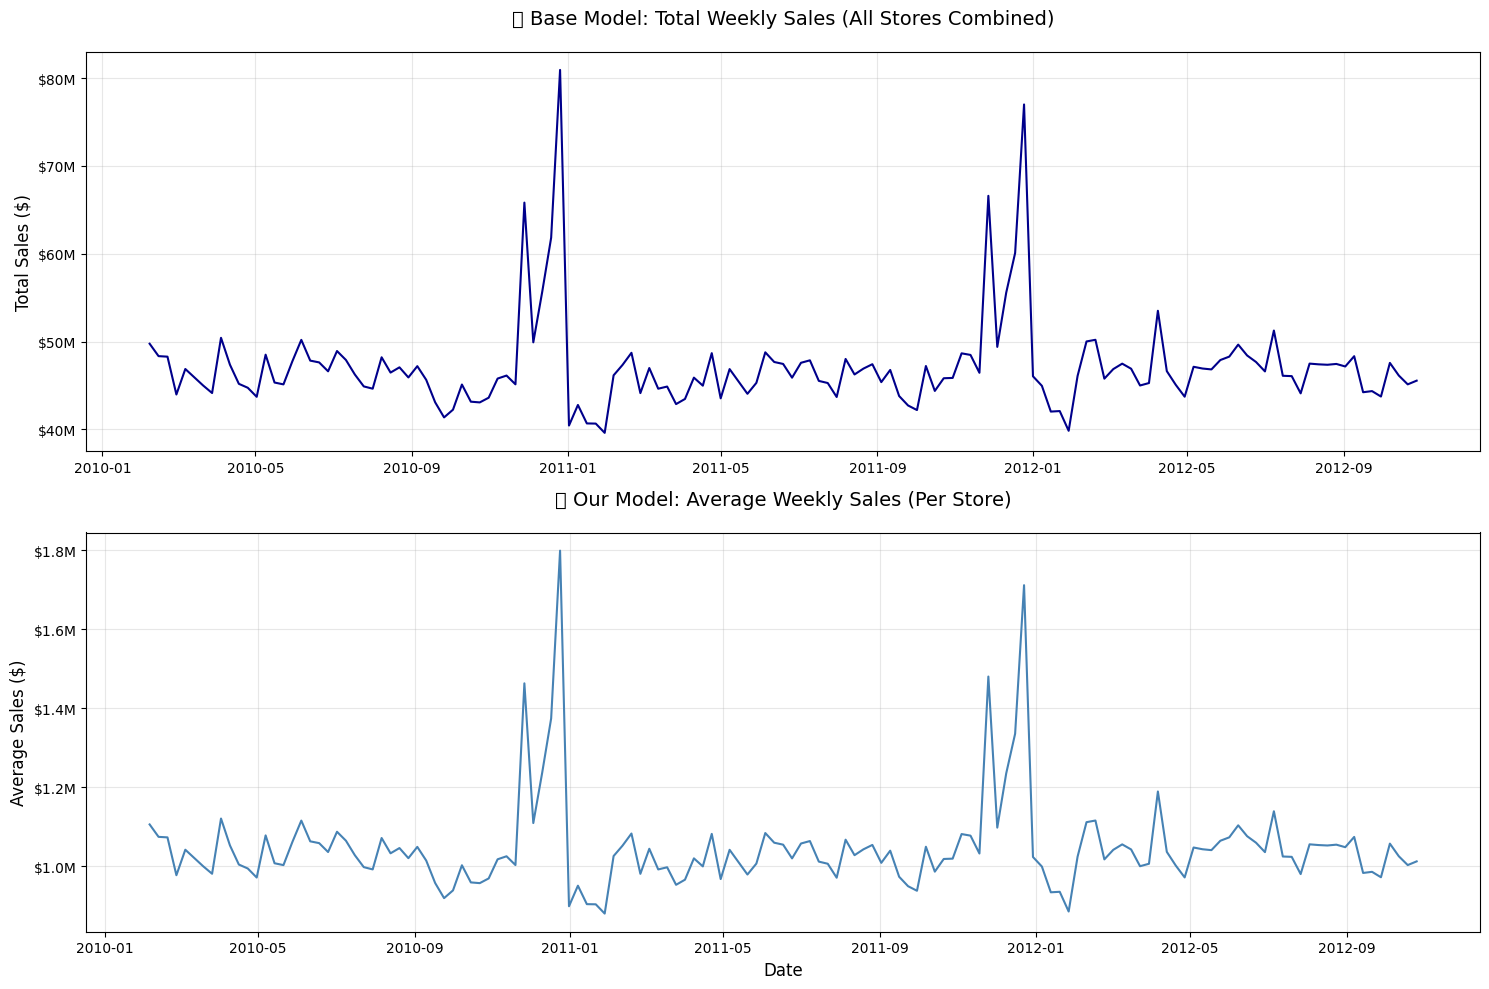

In [8]:
# Side-By-Side Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Total sales plot
ax1.plot(sales_total.index, sales_total.values, color='darkblue', linewidth=1.5)
ax1.set_title('📊 Base Model: Total Weekly Sales (All Stores Combined)', fontsize=14, pad=20)
ax1.set_ylabel('Total Sales ($)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.0f}M'))

# Average sales plot
ax2.plot(sales_avg.index, sales_avg.values, color='steelblue', linewidth=1.5)
ax2.set_title('🎯 Our Model: Average Weekly Sales (Per Store)', fontsize=14, pad=20)
ax2.set_ylabel('Average Sales ($)', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

plt.tight_layout()
plt.show()

### Stationary Testing

In [9]:
def adf_test(series, name):
    result = adfuller(series.dropna())
    is_stationary = result[1] <= 0.05

    print(f"\n{name}:")
    print(f"  ADF Statistic: {result[0]:.6f}")
    print(f"  p-value: {result[1]:.2e}")
    print(f"  Result: {'✅ STATIONARY' if is_stationary else '❌ NON-STATIONARY'}")

    return is_stationary

print(f"\n=== STATIONARITY ANALYSIS ===")
total_stationary = adf_test(sales_total, "Total Sales (Base Model)")
avg_stationary = adf_test(sales_avg, "Average Sales (Our Model)")



=== STATIONARITY ANALYSIS ===

Total Sales (Base Model):
  ADF Statistic: -5.908298
  p-value: 2.68e-07
  Result: ✅ STATIONARY

Average Sales (Our Model):
  ADF Statistic: -5.908298
  p-value: 2.68e-07
  Result: ✅ STATIONARY


## Sales Forecasting

### Calculate Moving Avergae

In [10]:
window = 4
forecast_weeks = 12


ma_total = sales_total.rolling(window=window).mean()
ma_avg = sales_avg.rolling(window=window).mean()

### Base Forecasts

In [11]:
base_total = ma_total.dropna().iloc[-1]
base_avg = ma_avg.dropna().iloc[-1]

# Create future dates
last_date = sales_total.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1),
                           periods=forecast_weeks, freq='W')

### Holiday Forecasts

In [12]:

holiday_boost = 1.078  # +7.8% from our analysis

# Holiday weeks (based on US retail calendar)
holiday_weeks = []
for i, date in enumerate(future_dates):
    is_holiday = False
    month = date.month
    day = date.day

    # Thanksgiving week (late November)
    if month == 11 and day >= 22:
        is_holiday = True
    # Christmas shopping season (December)
    elif month == 12:
        is_holiday = True
    # New Year week (early January)
    elif month == 1 and day <= 7:
        is_holiday = True

    holiday_weeks.append(is_holiday)

### Forecasts with Seasonality

In [13]:
forecast_avg_improved = []
forecast_total_improved = []

for i, is_holiday in enumerate(holiday_weeks):
    if is_holiday:
        avg_pred = base_avg * holiday_boost
    else:
        avg_pred = base_avg

    forecast_avg_improved.append(avg_pred)
    forecast_total_improved.append(avg_pred * data['Store'].nunique())

print(f"\n=== IMPROVED FORECASTING ({forecast_weeks} weeks) ===")
print(f"Base Moving Average: ${base_avg:,.0f} per store")
print(f"Holiday Boost Applied: +{(holiday_boost-1)*100:.1f}% for seasonal weeks")

print(f"\nForecast Summary:")
holiday_weeks_count = sum(holiday_weeks)
regular_weeks_count = forecast_weeks - holiday_weeks_count
avg_regular = base_avg
avg_holiday = base_avg * holiday_boost

print(f"  Regular weeks ({regular_weeks_count}): ${avg_regular:,.0f} per store")
print(f"  Holiday weeks ({holiday_weeks_count}): ${avg_holiday:,.0f} per store")
print(f"  Weighted average: ${np.mean(forecast_avg_improved):,.0f} per store")



=== IMPROVED FORECASTING (12 weeks) ===
Base Moving Average: $1,024,232 per store
Holiday Boost Applied: +7.8% for seasonal weeks

Forecast Summary:
  Regular weeks (5): $1,024,232 per store
  Holiday weeks (7): $1,104,122 per store
  Weighted average: $1,070,834 per store


## Forecast Visualizations

### Sales Forecast Plotted

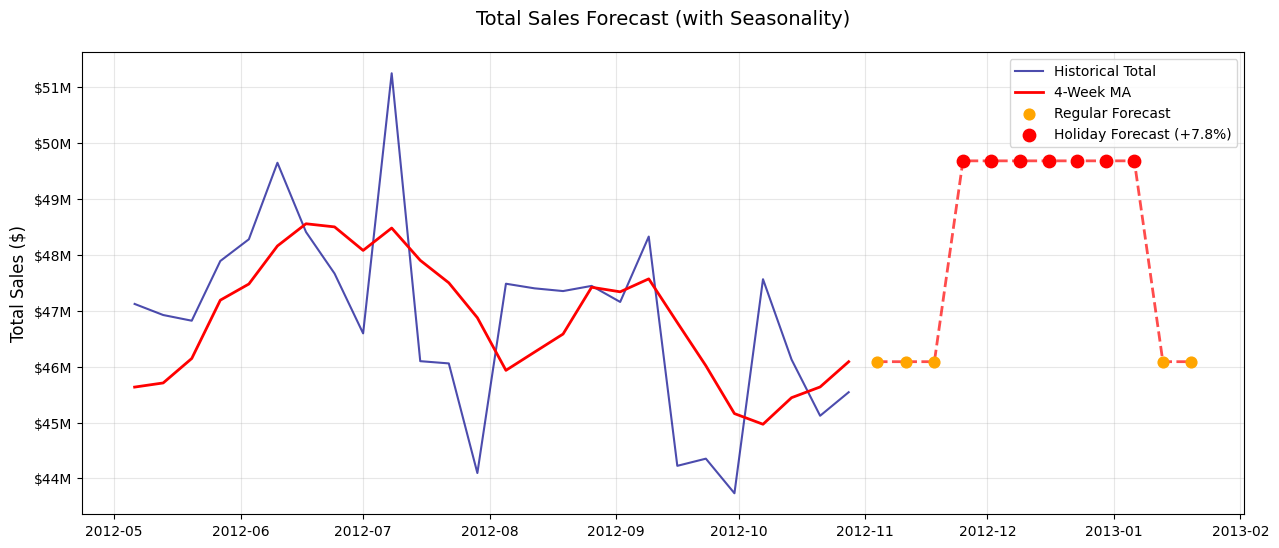

In [28]:
fig, ax = plt.subplots(figsize=(15, 6))

# Historical and moving average
ax.plot(recent_total.index, recent_total.values, label='Historical Total', color='darkblue', alpha=0.7)
ax.plot(recent_ma_total.index, recent_ma_total.values, label=f'{window}-Week MA', color='red', linewidth=2)

# Forecasts
ax.plot(future_dates, forecast_total_improved, color='red', linestyle='--', linewidth=2, alpha=0.7)
if regular_dates:
    ax.scatter(regular_dates, regular_values_total, color='orange', s=60, label='Regular Forecast', zorder=5)
if holiday_dates:
    ax.scatter(holiday_dates, holiday_values_total, color='red', s=80, label='Holiday Forecast (+7.8%)', zorder=5)

ax.set_title('Total Sales Forecast (with Seasonality)', fontsize=14, pad=20)
ax.set_ylabel('Total Sales ($)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.0f}M'))

plt.show()


### Detailed Forecast Matrix

In [29]:
print(f"\n=== DETAILED {forecast_weeks}-WEEK FORECAST (IMPROVED) ===")
print("Week | Date       | Holiday? | Total Sales    | Per Store Avg")
print("-" * 65)

total_forecast_sum = 0
total_per_store_sum = 0

for i, (date, is_holiday, total_pred, avg_pred) in enumerate(zip(future_dates, holiday_weeks, forecast_total_improved, forecast_avg_improved), 1):
    holiday_flag = "🎄 YES" if is_holiday else "   No"
    print(f"{i:2d}   | {date.strftime('%Y-%m-%d')} | {holiday_flag}    | ${total_pred:>12,.0f} | ${avg_pred:>11,.0f}")
    total_forecast_sum += total_pred
    total_per_store_sum += avg_pred

print("-" * 65)
print(f"TOTAL {forecast_weeks} WEEKS:                    ${total_forecast_sum:>12,.0f} | ${total_per_store_sum:>11,.0f}")



=== DETAILED 12-WEEK FORECAST (IMPROVED) ===
Week | Date       | Holiday? | Total Sales    | Per Store Avg
-----------------------------------------------------------------
 1   | 2012-11-04 |    No    | $  46,090,420 | $  1,024,232
 2   | 2012-11-11 |    No    | $  46,090,420 | $  1,024,232
 3   | 2012-11-18 |    No    | $  46,090,420 | $  1,024,232
 4   | 2012-11-25 | 🎄 YES    | $  49,685,473 | $  1,104,122
 5   | 2012-12-02 | 🎄 YES    | $  49,685,473 | $  1,104,122
 6   | 2012-12-09 | 🎄 YES    | $  49,685,473 | $  1,104,122
 7   | 2012-12-16 | 🎄 YES    | $  49,685,473 | $  1,104,122
 8   | 2012-12-23 | 🎄 YES    | $  49,685,473 | $  1,104,122
 9   | 2012-12-30 | 🎄 YES    | $  49,685,473 | $  1,104,122
10   | 2013-01-06 | 🎄 YES    | $  49,685,473 | $  1,104,122
11   | 2013-01-13 |    No    | $  46,090,420 | $  1,024,232
12   | 2013-01-20 |    No    | $  46,090,420 | $  1,024,232
-----------------------------------------------------------------
TOTAL 12 WEEKS:                    $ 578

### Calculate uplift from seasonality

In [18]:

simple_forecast_sum = base_total * forecast_weeks
seasonal_uplift = total_forecast_sum - simple_forecast_sum
uplift_percent = (seasonal_uplift / simple_forecast_sum) * 100

print(f"\nSEASONALITY IMPACT:")
print(f"  Simple forecast (no seasonality): ${simple_forecast_sum:,.0f}")
print(f"  Improved forecast (with holidays): ${total_forecast_sum:,.0f}")
print(f"  Additional revenue from holidays: ${seasonal_uplift:+,.0f} ({uplift_percent:+.1f}%)")


SEASONALITY IMPACT:
  Simple forecast (no seasonality): $553,085,041
  Improved forecast (with holidays): $578,250,411
  Additional revenue from holidays: $+25,165,369 (+4.5%)


### Top Performing Stores Analysis

In [19]:
store_performance = data.groupby('Store')['Weekly_Sales'].agg(['mean', 'sum']).round(0)
store_performance.columns = ['Avg_Weekly', 'Total_Sales']
top_stores = store_performance.sort_values('Avg_Weekly', ascending=False).head(5)

print(f"\n=== TOP 5 PERFORMING STORES ===")
print("Store | Avg Weekly Sales | Total Sales")
print("-" * 40)
for store, row in top_stores.iterrows():
    print(f"{store:2d}    | ${row['Avg_Weekly']:>12,.0f} | ${row['Total_Sales']:>11,.0f}")


=== TOP 5 PERFORMING STORES ===
Store | Avg Weekly Sales | Total Sales
----------------------------------------
20    | $   2,107,677 | $301,397,792
 4    | $   2,094,713 | $299,543,953
14    | $   2,020,978 | $288,999,911
13    | $   2,003,620 | $286,517,704
 2    | $   1,925,751 | $275,382,441


## Final Insights

### Correlation Analysis

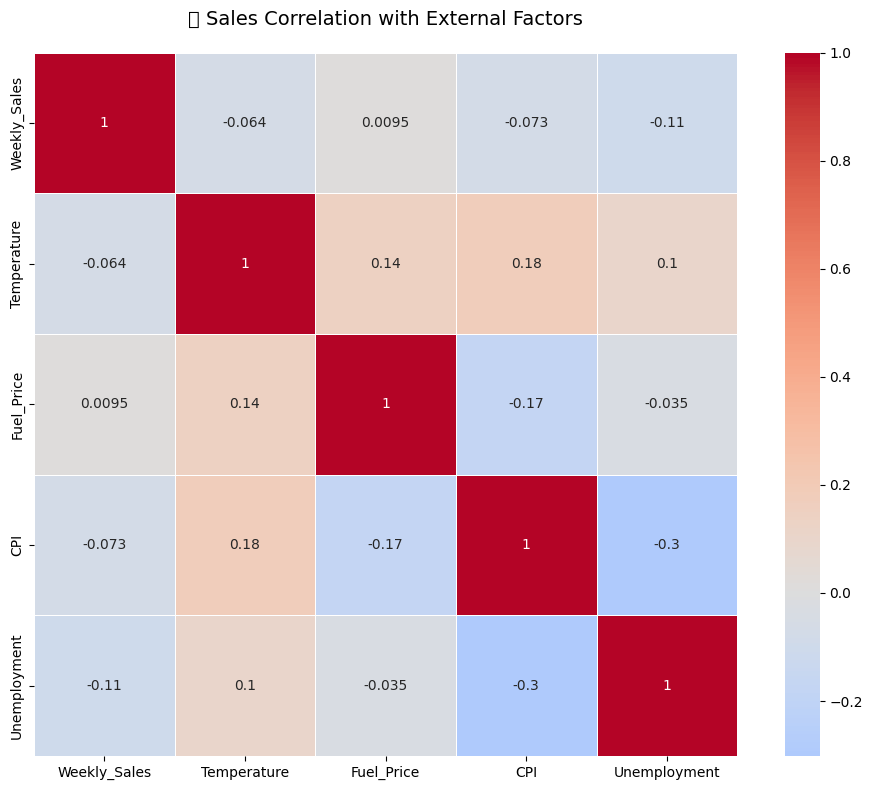

In [20]:
plt.figure(figsize=(10, 8))
numeric_cols = data[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].corr()
sns.heatmap(numeric_cols, annot=True, cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title('📈 Sales Correlation with External Factors', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Model Summary

In [25]:

print(f"\n" + "="*60)
print("ANALYSIS SUMMARY")
print("="*60)

print(f"\nMODEL COMPARISON:")
print(f"   Base Model: Forecasts company-wide total sales")
print(f"   Our Model:  Forecasts actionable per-store metrics")
print(f"   Both approaches are stationary and suitable for forecasting")

print(f"\n KEY INSIGHTS:")
print(f"   • Holiday sales boost: +{holiday_lift:.1f}%")
print(f"   • Store performance gap: {top_stores.iloc[0]['Avg_Weekly']/data['Weekly_Sales'].mean():.1f}x average")
print(f"   • {forecast_weeks}-week outlook: Stable sales expected")

print(f"\n RECOMMENDED ACTIONS:")
print(f"   • Use per-store forecasts for inventory planning")
print(f"   • Increase holiday staffing/inventory by ~8%")
print(f"   • Study top stores (#{top_stores.index[0]}, #{top_stores.index[1]}) for best practices")

print(f"\n" + "="*60)




ANALYSIS SUMMARY

MODEL COMPARISON:
   Base Model: Forecasts company-wide total sales
   Our Model:  Forecasts actionable per-store metrics
   Both approaches are stationary and suitable for forecasting

 KEY INSIGHTS:
   • Holiday sales boost: +7.8%
   • Store performance gap: 2.0x average
   • 12-week outlook: Stable sales expected

 RECOMMENDED ACTIONS:
   • Use per-store forecasts for inventory planning
   • Increase holiday staffing/inventory by ~8%
   • Study top stores (#20, #4) for best practices

